# importing & checking the data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (
    Dense,
    LSTM,
    RepeatVector,
    TimeDistributed,
    Flatten
)

from sklearn.metrics import r2_score

In [17]:
df=pd.read_csv(r'C:\Users\salehi\Desktop\lstmprojection\powerconsumption.csv')
df

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [18]:
df.columns

Index(['Datetime', 'Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3'],
      dtype='object')

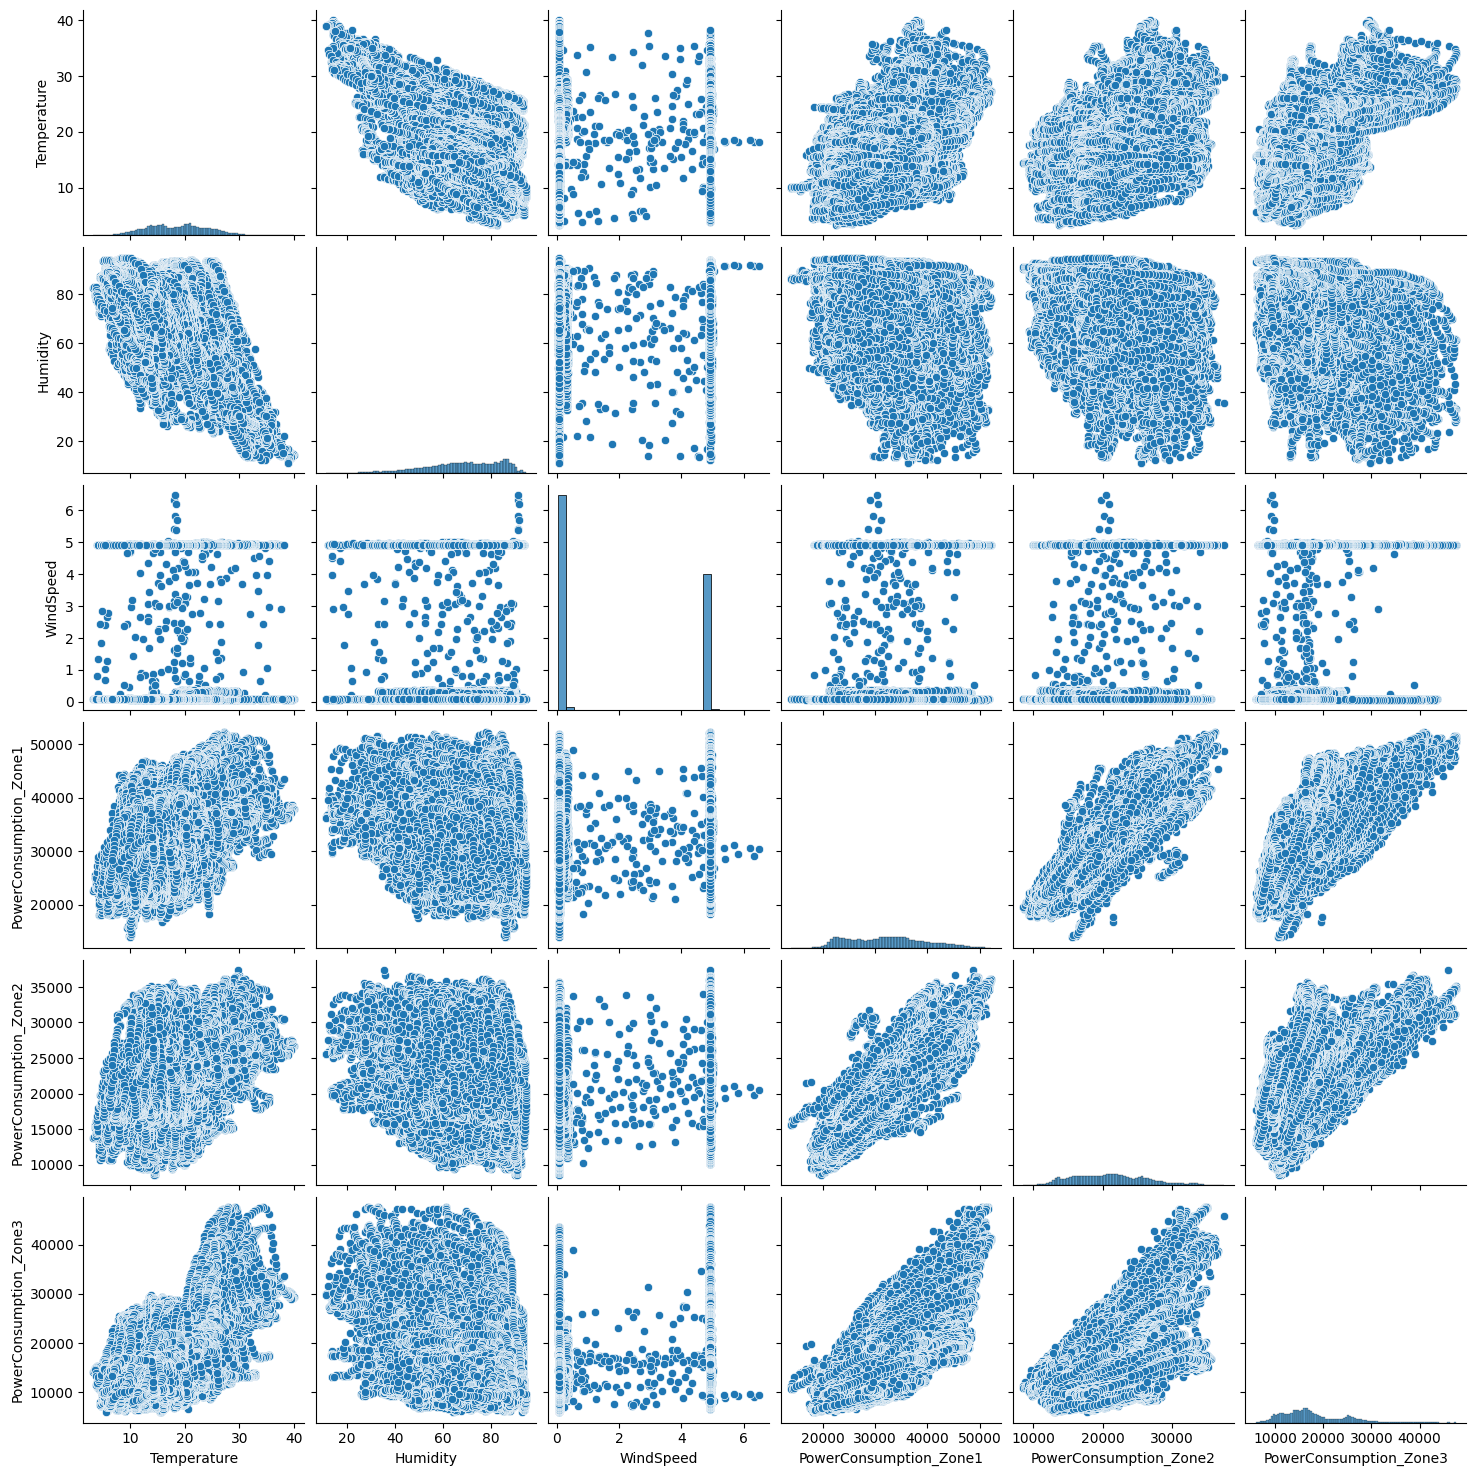

In [19]:
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed','PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.show()

In [20]:
df['Datetime'] = pd.to_datetime(df['Datetime'])



In [60]:
print(type(df.index))


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


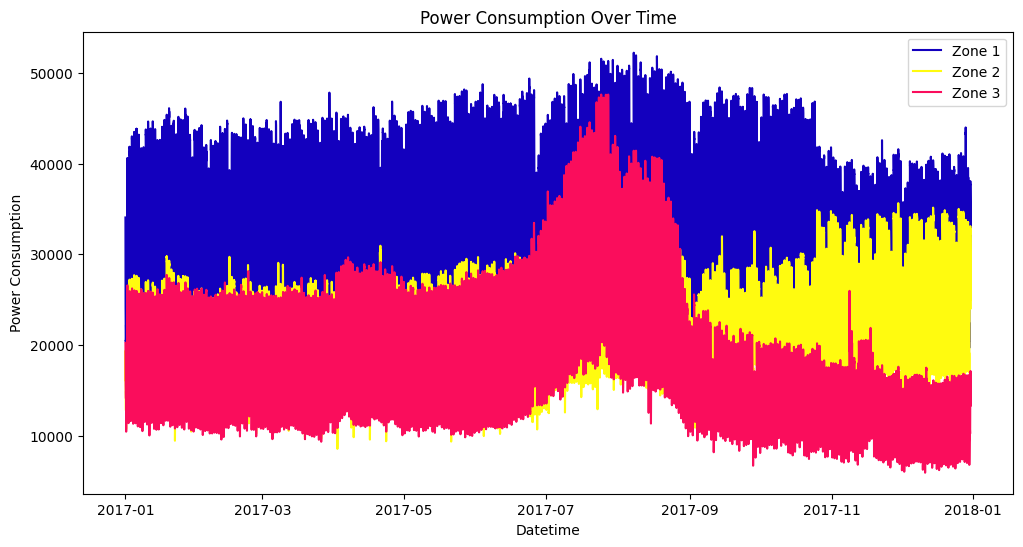

In [63]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['PowerConsumption_Zone1'], label='Zone 1',color="#1300be")
plt.plot(df.index, df['PowerConsumption_Zone2'], label='Zone 2',color="#fffb0f")
plt.plot(df.index, df['PowerConsumption_Zone3'], label='Zone 3',color="#fa0d5c")
plt.title('Power Consumption Over Time')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

In [22]:
df.sort_values(by='Datetime', ascending=True,inplace=True)
chronological_order=df['Datetime'].is_monotonic_increasing
time_diffs=df['Datetime'].diff()
equidistant_timestamps=time_diffs.nunique()==1

In [23]:
chronological_order, equidistant_timestamps

(True, True)

In [24]:
df.isnull().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [25]:
def create_features(df):
    df = df.copy()

    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)

    df['season'] = (df['month'] % 12 // 3 + 1)

    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_working_day'] = df['dayofweek'].isin([0,1,2,3,4]).astype(int)

    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)

    df['is_quarter_start'] = (
        (df['dayofmonth'] == 1) & (df['month'] % 3 == 1)
    ).astype(int)

    df['is_quarter_end'] = (
        df['dayofmonth'] ==
        df.groupby(['year', 'quarter'])['dayofmonth'].transform('max')
    ).astype(int)

    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)

    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = df['dayofweek'] * 1440 + df['minute_of_day']

    return df


In [26]:
df=df.set_index('Datetime')
df=create_features(df)

In [27]:
df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,minute,...,is_weekend,is_working_day,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_business_hours,is_peak_hour,minute_of_day,minute_of_week
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,0,...,1,0,1,0,1,0,0,0,0,8640
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,10,...,1,0,1,0,1,0,0,0,10,8650
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,20,...,1,0,1,0,1,0,0,0,20,8660
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,30,...,1,0,1,0,1,0,0,0,30,8670
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,40,...,1,0,1,0,1,0,0,0,40,8680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,23,10,...,1,0,0,0,0,0,0,0,1390,8590
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,23,20,...,1,0,0,0,0,0,0,0,1400,8600
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,23,30,...,1,0,0,0,0,0,0,0,1410,8610


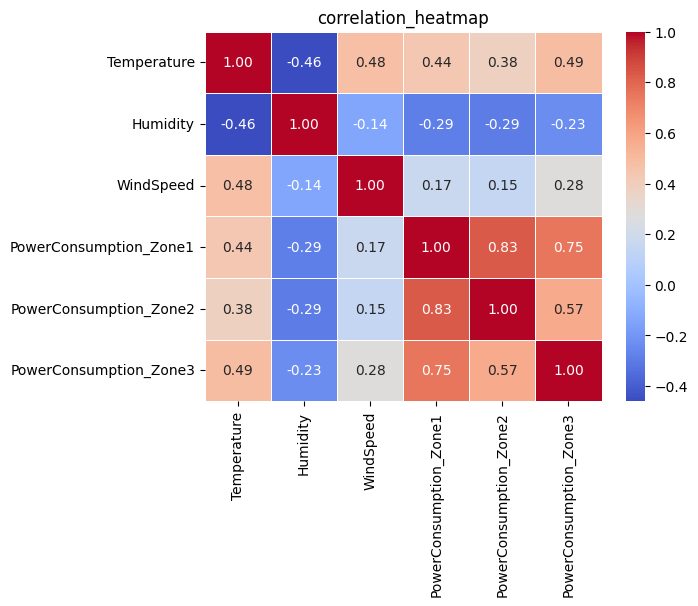

In [29]:
corrmatrix=df[['Temperature', 'Humidity', 'WindSpeed', 
               'PowerConsumption_Zone1','PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()
plt.Figure(figsize=(1,8))
sns.heatmap(corrmatrix,annot=True,cmap='coolwarm',fmt='.2f',linewidth=0.5)
plt.title('correlation_heatmap')
plt.show()

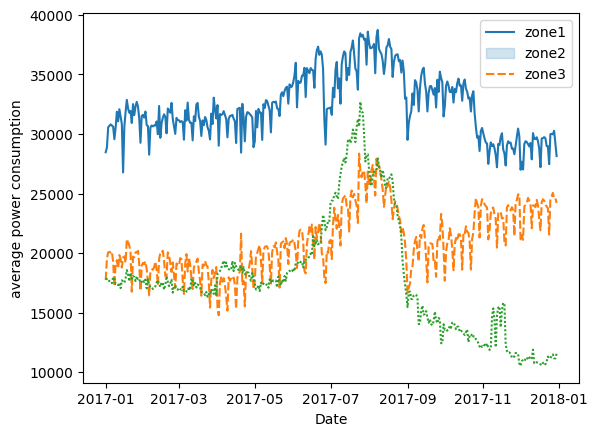

In [30]:
daily_resampled=df.resample('D').mean()
plt.Figure(figsize=(12,6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1', 
                                   'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel('Date')
plt.ylabel('average power consumption')
plt.legend(labels=['zone1','zone2','zone3'])
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler_y = StandardScaler()




x = df.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
y = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]
y_scaled = scaler_y.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    x, y_scaled ,test_size=0.25, shuffle=False
)





In [32]:
y_test

array([[-0.08265162, -0.58781045, -0.44343015],
       [-0.16396171, -0.65960705, -0.49895022],
       [-0.30713819, -0.74863482, -0.53067598],
       ...,
       [-0.38624194,  0.81423659, -0.60840556],
       [-0.47497346,  0.70167962, -0.65278385],
       [-0.56029223,  0.57921197, -0.67801856]], shape=(13104, 3))

In [33]:
epoch=40
batch=256
lr=0.0003
adam=optimizers.Adam(lr)


In [34]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(3))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

c:\Users\salehi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,903 (11.34 KB)

 Trainable params: 2,903 (11.34 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
mlp_history = model_mlp.fit(
    X_train.values,
    y_train,
    validation_data=(X_test.values, y_test),
    epochs=epoch,
    verbose=2
)


Epoch 1/40
1229/1229 - 9s - 7ms/step - loss: 5417.2495 - val_loss: 68.3099
Epoch 2/40
1229/1229 - 8s - 7ms/step - loss: 20.0256 - val_loss: 24.4282
Epoch 3/40
1229/1229 - 5s - 4ms/step - loss: 7.4391 - val_loss: 16.0890
Epoch 4/40
1229/1229 - 5s - 4ms/step - loss: 4.5632 - val_loss: 11.9015
Epoch 5/40
1229/1229 - 4s - 4ms/step - loss: 3.3976 - val_loss: 8.7798
Epoch 6/40
1229/1229 - 4s - 3ms/step - loss: 2.7651 - val_loss: 6.9867
Epoch 7/40
1229/1229 - 5s - 4ms/step - loss: 2.7225 - val_loss: 7.9169
Epoch 8/40
1229/1229 - 5s - 4ms/step - loss: 2.2605 - val_loss: 7.6276
Epoch 9/40
1229/1229 - 4s - 3ms/step - loss: 2.2741 - val_loss: 6.6241
Epoch 10/40
1229/1229 - 5s - 4ms/step - loss: 2.0465 - val_loss: 4.0880
Epoch 11/40
1229/1229 - 4s - 3ms/step - loss: 1.9461 - val_loss: 5.9500
Epoch 12/40
1229/1229 - 4s - 3ms/step - loss: 1.9855 - val_loss: 7.4739
Epoch 13/40
1229/1229 - 5s - 4ms/step - loss: 1.5501 - val_loss: 3.3151
Epoch 14/40
1229/1229 - 5s - 4ms/step - loss: 1.8753 - val_loss: 

In [36]:
train_predict=model_mlp.predict(X_train)
test_predict=model_mlp.predict(X_test)
mse=mean_squared_error(y_test,test_predict)
mae=mean_absolute_error(y_test,test_predict)
print('meansquared error o test set:{:.4f}'.format(mse))
print('mean absolute error on test set:{:.4f}'.format(mae))


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
meansquared error o test set:6.2017
mean absolute error on test set:2.1426


In [37]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (39312, 25, 1)
Validation set shape (13104, 25, 1)


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model_cnn = Sequential([
    Conv1D(
        filters=32,
        kernel_size=3,
        activation='relu',
        input_shape=(25, 1)
    ),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3)
])

model_cnn.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='mse'
)

model_cnn.summary()


c:\Users\salehi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 23, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        22,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,915 (89.51 KB)

 Trainable params: 22,915 (89.51 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
cnn_history = model_cnn.fit(
    X_train_series,
    y_train,
    validation_data=(X_test_series, y_test),
    epochs=epoch,
    verbose=2
)


Epoch 1/40
1229/1229 - 7s - 6ms/step - loss: 298.5261 - val_loss: 2.5570
Epoch 2/40
1229/1229 - 6s - 5ms/step - loss: 0.7775 - val_loss: 2.8441
Epoch 3/40
1229/1229 - 6s - 4ms/step - loss: 0.5199 - val_loss: 1.2640
Epoch 4/40
1229/1229 - 6s - 5ms/step - loss: 0.4995 - val_loss: 1.3147
Epoch 5/40
1229/1229 - 10s - 8ms/step - loss: 0.5055 - val_loss: 1.8838
Epoch 6/40
1229/1229 - 10s - 9ms/step - loss: 0.5464 - val_loss: 2.0832
Epoch 7/40
1229/1229 - 6s - 5ms/step - loss: 0.5543 - val_loss: 0.9120
Epoch 8/40
1229/1229 - 6s - 5ms/step - loss: 0.4991 - val_loss: 1.9701
Epoch 9/40
1229/1229 - 7s - 5ms/step - loss: 0.4931 - val_loss: 1.7201
Epoch 10/40
1229/1229 - 8s - 7ms/step - loss: 0.4727 - val_loss: 1.7063
Epoch 11/40
1229/1229 - 7s - 6ms/step - loss: 0.4433 - val_loss: 4.4273
Epoch 12/40
1229/1229 - 9s - 8ms/step - loss: 0.4487 - val_loss: 5.2799
Epoch 13/40
1229/1229 - 10s - 8ms/step - loss: 0.4248 - val_loss: 3.4435
Epoch 14/40
1229/1229 - 10s - 8ms/step - loss: 0.4232 - val_loss: 2.

In [40]:
train_predict = model_cnn.predict(X_train)
test_predict = model_cnn.predict(X_test)



mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)


print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

1229/1229 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean squared error on test set: 3.6086
Mean absolute error on test set: 1.4772


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

model_lstm = Sequential([
    LSTM(
        units=50,
        activation='tanh',        
        input_shape=(25, 1)
    ),
    Dense(3)
])


c:\Users\salehi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
model_lstm.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='mse'
)


In [43]:
model_lstm.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,553 (41.22 KB)

 Trainable params: 10,553 (41.22 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
lstm_history = model_lstm.fit(
    X_train_series,
    y_train,
    validation_data=(X_test_series, y_test),
    epochs=epoch,
    verbose=2
)


Epoch 1/40
1229/1229 - 25s - 21ms/step - loss: 0.6054 - val_loss: 1.4073
Epoch 2/40
1229/1229 - 18s - 15ms/step - loss: 0.2944 - val_loss: 1.5761
Epoch 3/40
1229/1229 - 22s - 18ms/step - loss: 0.2248 - val_loss: 1.4401
Epoch 4/40
1229/1229 - 21s - 17ms/step - loss: 0.2004 - val_loss: 1.3457
Epoch 5/40
1229/1229 - 19s - 15ms/step - loss: 0.1849 - val_loss: 1.3242
Epoch 6/40
1229/1229 - 20s - 16ms/step - loss: 0.1754 - val_loss: 1.2903
Epoch 7/40
1229/1229 - 19s - 16ms/step - loss: 0.1682 - val_loss: 1.2327
Epoch 8/40
1229/1229 - 20s - 16ms/step - loss: 0.1613 - val_loss: 1.1887
Epoch 9/40
1229/1229 - 20s - 16ms/step - loss: 0.1538 - val_loss: 1.1288
Epoch 10/40
1229/1229 - 21s - 17ms/step - loss: 0.1479 - val_loss: 1.1137
Epoch 11/40
1229/1229 - 18s - 15ms/step - loss: 0.1427 - val_loss: 1.0579
Epoch 12/40
1229/1229 - 19s - 15ms/step - loss: 0.1397 - val_loss: 0.9946
Epoch 13/40
1229/1229 - 19s - 15ms/step - loss: 0.1355 - val_loss: 0.9823
Epoch 14/40
1229/1229 - 20s - 16ms/step - loss:

In [45]:
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)


# Calculate MSE and MAE as you already did
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Print the results
print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

1229/1229 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Mean squared error on test set: 0.5923
Mean absolute error on test set: 0.5835


In [46]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_dist = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05],
    'subsample': [0.7, 0.9],
    'min_child_weight': [1, 2]
}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=400,          # خیلی مهم
    tree_method='hist',        # سریع‌تر روی CPU
    n_jobs=-1,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,                 # کل مدل‌ها = 20 × 3 = 60
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 0.9, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.05}
Best score: -0.3909378180903056


In [47]:
model = random_search.best_estimator_


In [48]:
xgboost_history = model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=200)

[0]	validation_0-rmse:0.93898	validation_1-rmse:1.07223
[200]	validation_0-rmse:0.08353	validation_1-rmse:0.52945
[399]	validation_0-rmse:0.05911	validation_1-rmse:0.52942


In [49]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)

Mean squared error on test set:  0.28029082076565515
Mean absolute error on test set:  0.4168328205416467


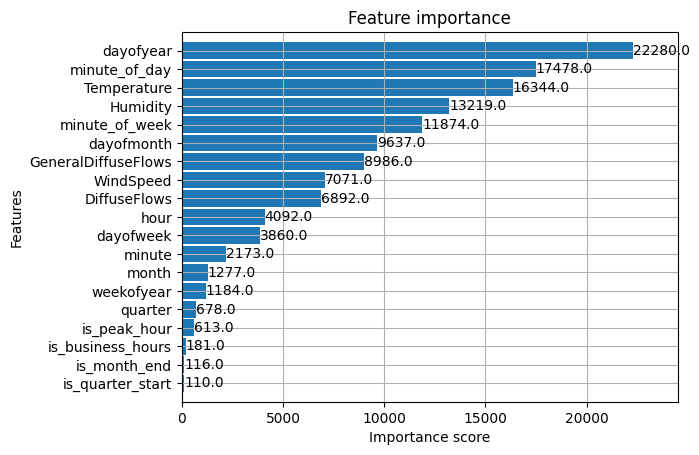

In [50]:
# Feature Importances
_ = plot_importance(model, height=0.9)

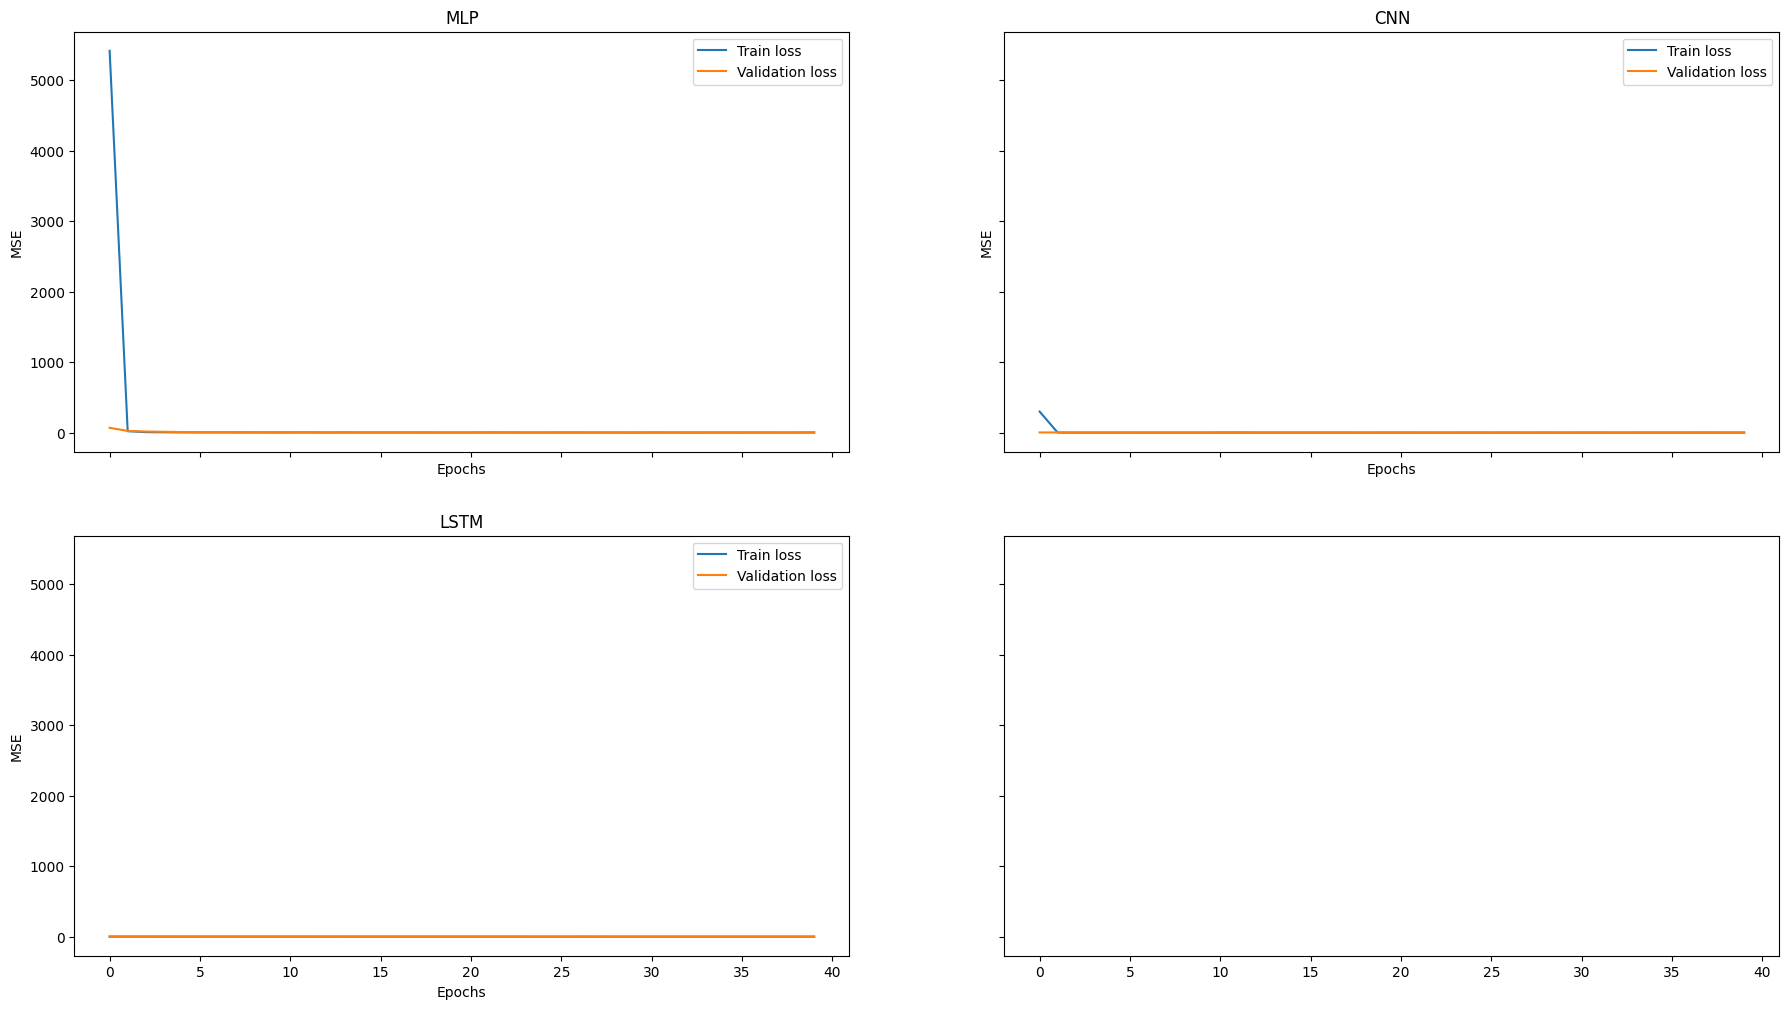

In [51]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

# ax3.plot(xgboost_history.history['loss'], label='Train loss')
# ax3.plot(xgboost_history.history['val_loss'], label='Validation loss')
# ax3.legend(loc='best')
# ax3.set_title('Xgboost')
# ax3.set_xlabel('Epochs')
# ax3.set_ylabel('MSE')
plt.show()



# Done